<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# torch.__version__
# !pip uninstall torch -y
# !pip install torch==1.11.0

In [2]:
!nvidia-smi

Sun Feb  5 20:45:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

Notes:
- I have no labels for test here, so I am dropping 'test.zip' related code. I can split train into train, val, test; in fact I don't want to have a lot of examples for train set.
- The sets are almost balanced, accuracy is ok here

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(13)
if device =='cuda':
    torch.cuda.manual_seed_all(13)

In [5]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
subset_bad_crops_path = '/content/drive/MyDrive/cats_n_dogs_unsure/cat_dogs_crops_from_test_20k_filtered.zip'
subset_multi_path = '/content/drive/MyDrive/cat_dogs_8_contats_50_50_from_test.zip'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [6]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [7]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

with zipfile.ZipFile(subset_bad_crops_path) as bad_crops_zip:
    bad_crops_zip.extractall('local_data')

with zipfile.ZipFile(subset_multi_path) as multi_zip:
    multi_zip.extractall('local_data')

In [8]:
os.listdir(train_dir)[:5]
os.listdir('/content/local_data/cat_dogs_8_contats_50_50_from_test')[:5]

['cat_dog_50_50_8concats_2442_224x224resize.jpg',
 'cat_dog_50_50_8concats_195_224x224resize.jpg',
 'cat_dog_50_50_8concats_1971_224x224resize.jpg',
 'cat_dog_50_50_8concats_1691_224x224resize.jpg',
 'cat_dog_50_50_8concats_1246_224x224resize.jpg']

In [9]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
bad_cats_generated_from_test_list = sorted(glob.glob(os.path.join("local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats",'cat*.jpg')))
bad_dogs_generated_from_test_list = sorted(glob.glob(os.path.join("local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs",'dog*.jpg')))
concat_8_50_50_list = sorted(glob.glob(os.path.join("local_data/cat_dogs_8_contats_50_50_from_test/",'cat_dog_50_50_8concats_*_224x224resize.jpg')))

print(concat_8_50_50_list[:5])
print(len(concat_8_50_50_list))

print(len(bad_cats_generated_from_test_list))
print(len(bad_dogs_generated_from_test_list))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


random.seed(13)
random.shuffle(bad_cats_generated_from_test_list)
random.seed(13)
random.shuffle(bad_dogs_generated_from_test_list)
print(bad_cats_generated_from_test_list[:3])
print(bad_dogs_generated_from_test_list[:3])
assert bad_cats_generated_from_test_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.5232_crop_e_2.jpg'
assert bad_dogs_generated_from_test_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.3799_crop_e_2.jpg'

['local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_0_224x224resize.jpg', 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1000_224x224resize.jpg', 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1001_224x224resize.jpg', 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1002_224x224resize.jpg', 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1003_224x224resize.jpg']
2500
1866
1866
12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']
['local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.2865_crop_e_0.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.5232_crop_e_2.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.1459_crop_e_2.jpg']
['local_data/cat_dogs_crops_from_test

In [10]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
# subset_train_list = cats_list[:500] + dogs_list[:500]
# subset_train_list = cats_list[:1000] + dogs_list[:1000]
# subset_train_list = cats_list[:2000] + dogs_list[:2000]
# subset_train_list = cats_list[:250] + dogs_list[:250]
# subset_train_list = cats_list[:150] + dogs_list[:150]
# subset_train_list = cats_list[:250] + dogs_list[:250] + bad_cats_generated_from_test_list[:100] + bad_dogs_generated_from_test_list[:100]
# subset_train_list = cats_list[:500] + dogs_list[:500] + bad_cats_generated_from_test_list[:200] + bad_dogs_generated_from_test_list[:200]

# subset_train_list = cats_list[:50] + dogs_list[:50] + bad_cats_generated_from_test_list[:20] + bad_dogs_generated_from_test_list[:20]

# subset_train_list = cats_list[:2000] + dogs_list[:2000] + bad_cats_generated_from_test_list[:800] + bad_dogs_generated_from_test_list[:800]
# subset_train_list = cats_list[:1000] + dogs_list[:1000] + bad_cats_generated_from_test_list[:400] + bad_dogs_generated_from_test_list[:400]
subset_train_list = cats_list[:1000] + dogs_list[:1000] + concat_8_50_50_list[:400]

val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(subset_train_list),len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
# assert subset_train_list[4] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.2922_crop_e_0.jpg' #500 + 200 bad crop imgs train
# assert subset_train_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.4044_crop_e_3.jpg' #1000 + 400 bad crop imgs train
# assert subset_train_list[3] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.4554_crop_e_2.jpg' #100 + 40 bad crop imgs train
# assert subset_train_list[0] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.501_crop_e_0.jpg' #2000 + 800 bad crop imgs train
assert subset_train_list[3] == 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1123_224x224resize.jpg' #2000 + 400 0.5 0.5

# assert subset_train_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.4650_crop_e_0.jpg' #4000 + 1600 bad crop imgs train

# assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
# assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.445.jpg' # 1000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.7661.jpg' # 300 imgs
# assert subset_train_list[4] == 'local_data/train/cat.9914.jpg' #100 imgs
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

2400 15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/cat.2046.jpg', 'local_data/train/cat.11686.jpg', 'local_data/train/dog.2580.jpg', 'local_data/cat_dogs_8_contats_50_50_from_test/cat_dog_50_50_8concats_1123_224x224resize.jpg', 'local_data/train/dog.9371.jpg', 'local_data/train/cat.11478.jpg', 'local_data/train/dog.4427.jpg', 'local_data/train/dog.8248.jpg', 'local_data/train/dog.3486.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'local_data/train/cat.1815.jpg', 'local_data/train/dog.5218.jpg', 'local_data/train/dog.5240.jpg']
test [

In [11]:
train_list = subset_train_list # 5 batches # or 20 batches
# train_list = full_train_list

[ 939  835  540 2120  383 1111  304 1629 1046 1432]


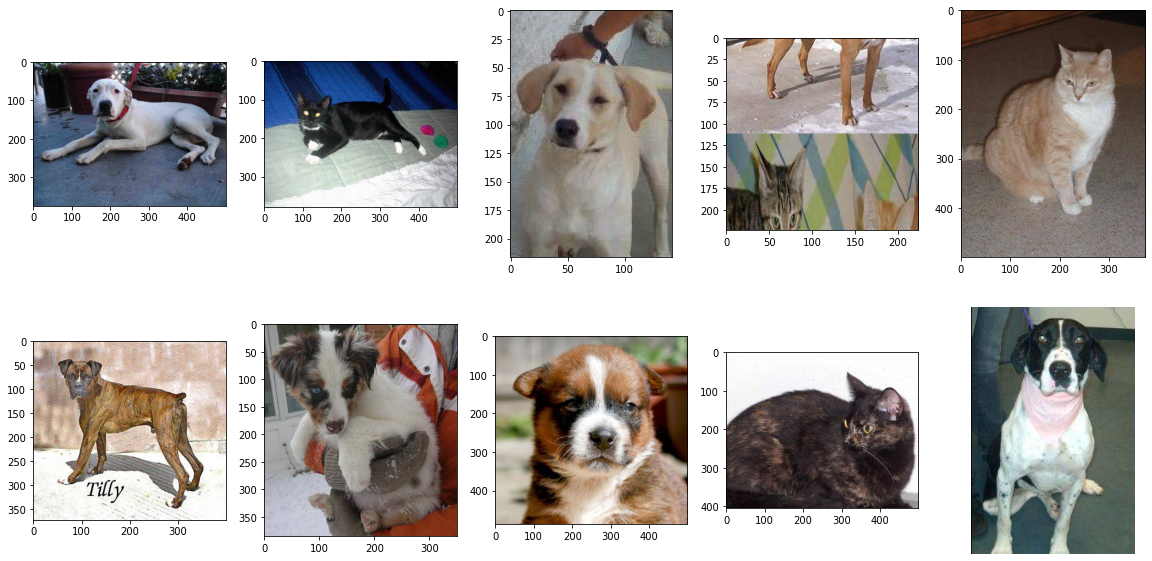

In [12]:
np.random.seed(13131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

# Data Augmentation

In [13]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.9, 1.0)), 
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

val_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transforms = transforms.Compose([   
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

In [14]:
def get_hard_label(img_path):
  label = img_path.split('/')[-1].split('.')[0]
  if label == 'dog':
    return 1
  elif label == 'cat':
    return 0

def get_soft_label_inbalanced(img_path):
  label = img_path.split('/')[-1].split('.')[0]
  if label == 'dog':
      if "crop" in img_path:
        return torch.FloatTensor([0.7,0.3])
      else:
        return torch.FloatTensor([1.0,0.0])
  elif label == 'cat':
      if "crop" in img_path:
        return torch.FloatTensor([0.3,0.7])
      else:
        return torch.FloatTensor([0.0,1.0])

def get_soft_label_balanced(img_path):
  label = img_path.split('/')[-1].split('.')[0]
  if "cat" in label and "dog" in label and "concat" in label:
      return torch.FloatTensor([0.5,0.5])
  elif label == 'dog':
      return torch.FloatTensor([1.0,0.0])
  elif label == 'cat':
      return torch.FloatTensor([0.0,1.0])

In [15]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        # print("===========")
        # print("img path", img_path)
        label = get_soft_label_balanced(img_path)

        # print("label", label)
            
        return img_transformed,label

In [16]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [17]:
batch_size = 100 # we will use mini-batch method
# batch_size = 4 # 10 TODO change this after going back to GPU! this is because notebook crashes when whole RAM is used # using 1 because of soft softmax bug/opti in pytorch

In [18]:
train_data = dataset(train_list, transform=train_transforms)
val_data = dataset(val_list, transform=val_transforms)
test_data = dataset(test_list, transform=test_transforms)
visualise_train_dataset = dataset(train_list, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
vis_train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=False)

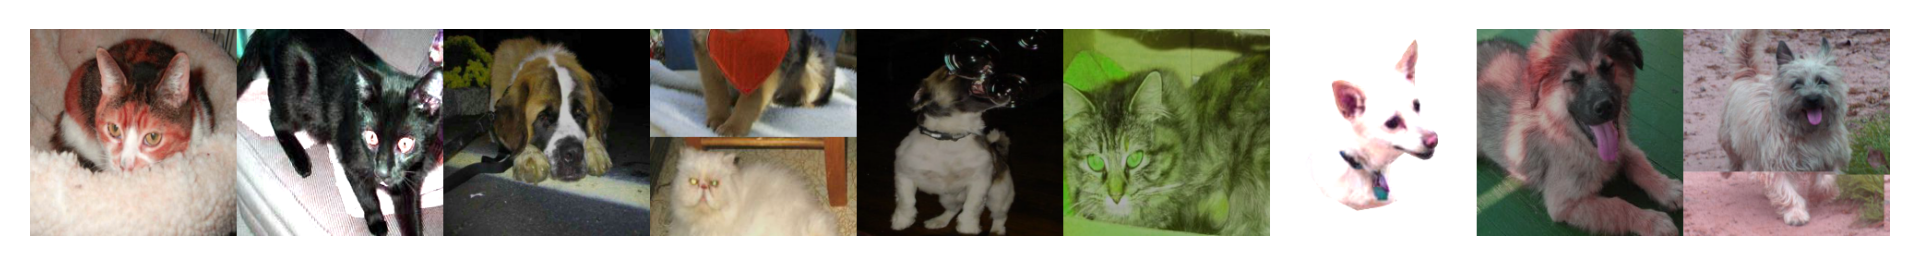

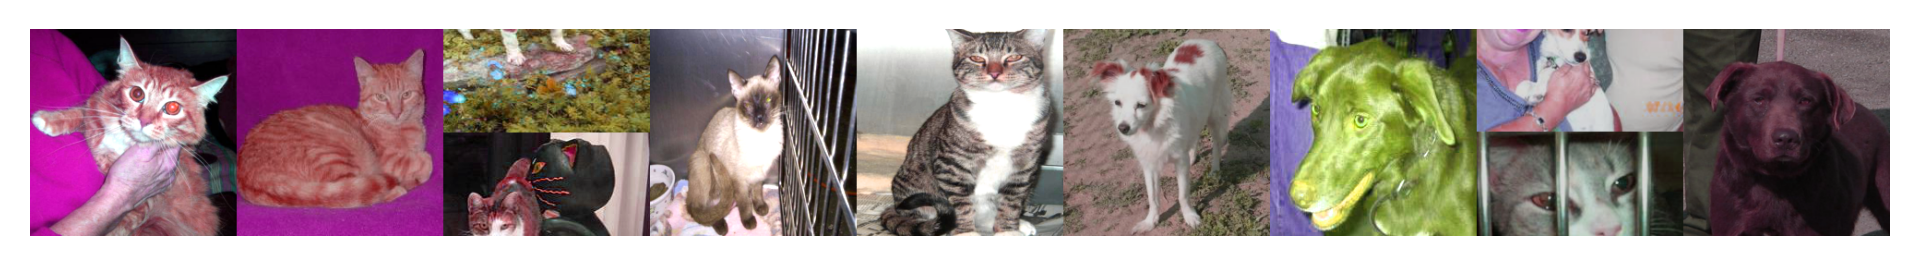

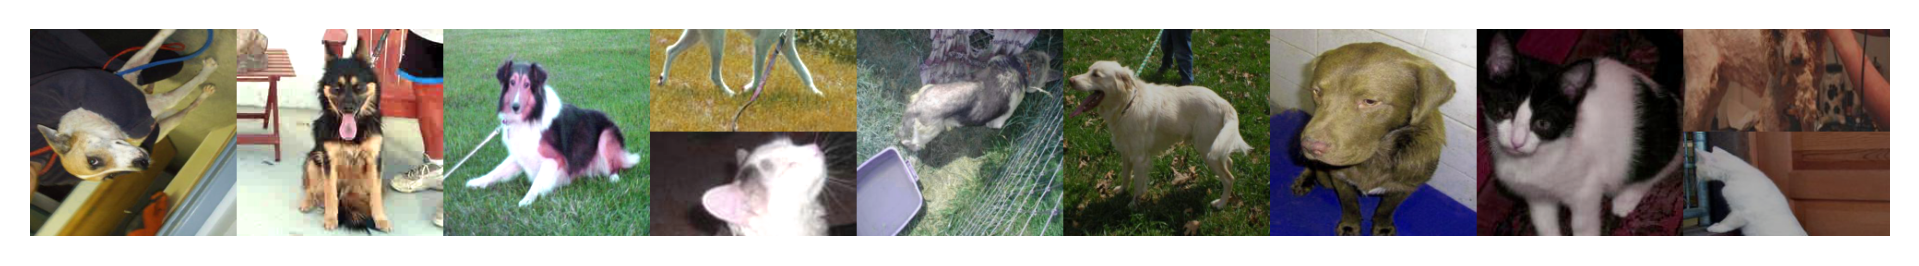

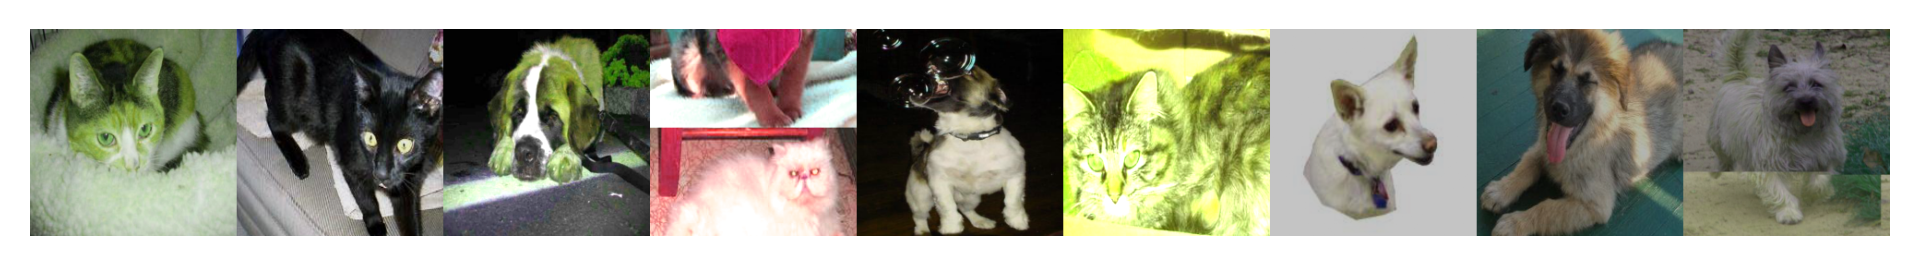

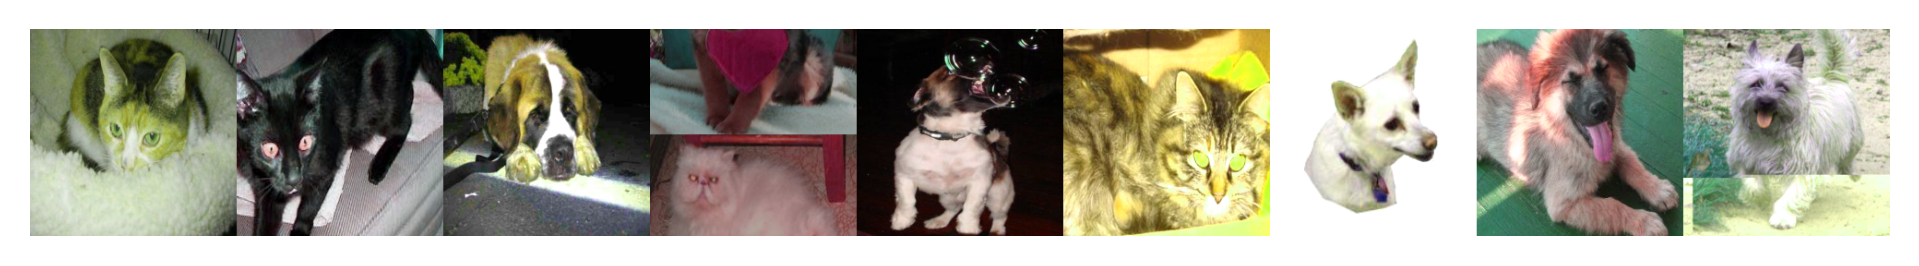

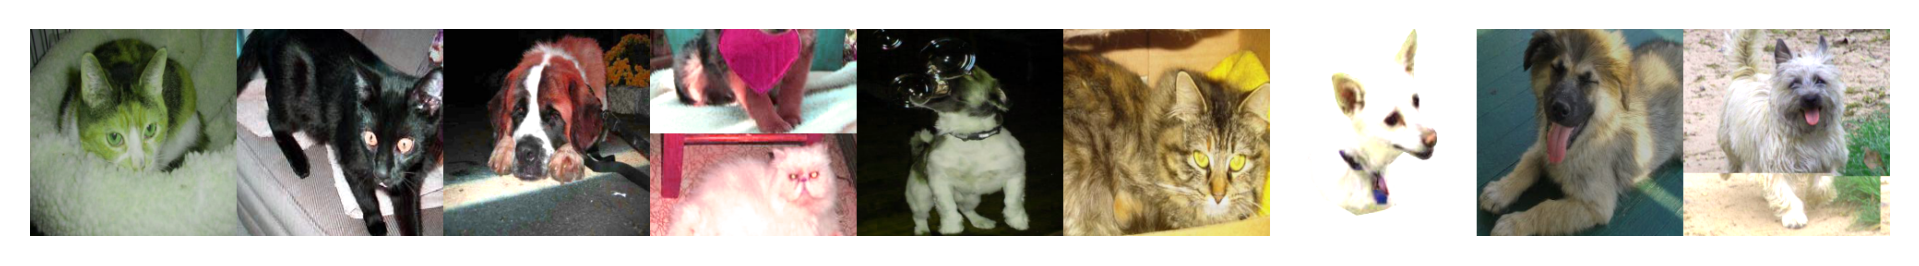

In [19]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(vis_train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))

In [20]:
print(len(train_data), len(train_loader), len(test_loader))

2400 24 50


In [21]:
print(sum(1 for filename in train_data.file_list if 'cat' in filename))
print(sum(1 for filename in train_data.file_list if 'dog' in filename))
print(sum(1 for filename in val_data.file_list if 'cat' in filename))
print(sum(1 for filename in val_data.file_list if 'dog' in filename))
print(sum(1 for filename in test_data.file_list if 'cat' in filename))
print(sum(1 for filename in test_data.file_list if 'dog' in filename))

1400
1400
2500
2500
2500
2500


In [22]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [23]:
# activations = torch.FloatTensor([[-0.3139, -0.0486],
# [-0.0510,  0.0470],
# [ 0.0963,  0.0143],
# [-0.2151, -0.0576]])

# targets_float = torch.FloatTensor([1.0, 1.0, 0.0, 0.5])
# targets_long = torch.LongTensor([1, 1, 0, 0])
# targets_float = torch.FloatTensor([[t, 1-t] for t in targets_float])
# print(targets_float)
# print(targets_float.shape)
# crit = nn.CrossEntropyLoss()
# crit(activations,targets_long) # tensor(0.6606)
# crit(activations,targets_float) 
# # return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
# # RuntimeError: expected scalar type Long but found Float

In [24]:
class Experiment:
  epochs = 100 #10
  min_val_loss = float('inf')
  epochs_since_min_loss = 0
  patience = 7
  final_scores = {}  

  def __init__(self):
    self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
    self.model.classifier[-1] = nn.Linear(in_features=1280, out_features=2, bias=True)
    self.model = self.model.to(device).train()
    self.optimizer = optim.Adam(params = self.model.parameters(),lr=0.001)
    self.criterion = nn.CrossEntropyLoss()

  def eval_model(self, loader: torch.utils.data.dataloader.DataLoader, model: nn.Module, description: str="Evaluation:") -> tuple: #[torch.Tensor, torch.Tensor] detailed tuple types only in Python >3.9, colab has 3.8.16
    epoch_accuracy=0
    epoch_loss =0
    with torch.no_grad():
      with tqdm(loader, unit="iteration") as tqdm_wrapped_loader:
        tqdm_wrapped_loader.set_description(description)
        for data, label in tqdm_wrapped_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            # print(output, label)
            # loss = run.criterion(output,label.float())
            loss = run.criterion(output,label)


            # acc = ((output.argmax(dim=1) == label).float().mean())
            acc = ((output.argmax(dim=1) == label.argmax(dim=1)).float().mean())

            epoch_accuracy += acc/ len(loader)
            epoch_loss += loss/ len(loader)
            tqdm_wrapped_loader.set_postfix(epoch_accuracy=epoch_accuracy, loss=epoch_loss)
    return epoch_accuracy, epoch_loss

  def train(self):
      for epoch in range(self.epochs):
          print("\n","="*30,"\n")
          epoch_loss = 0
          epoch_accuracy = 0
          
          with tqdm(train_loader, unit="iteration") as tepoch:
            
            for data, label in tepoch:
                tepoch.set_description(f"Training epoch {epoch}")
                data = data.to(device)
                label = label.to(device)
                
                output = run.model(data)
                # print("output train", output, output.shape)

                # print("target train", label)
                loss = run.criterion(output, label)
                # loss = run.criterion(output, label.float())
                
                run.optimizer.zero_grad()
                loss.backward()
                run.optimizer.step()
                
                acc = ((output.argmax(dim=1) == label.argmax(dim=1)).float().mean())

                # acc = ((output.argmax(dim=1) == label).float().mean())

                epoch_accuracy += acc/len(train_loader)
                epoch_loss += loss/len(train_loader)
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
            print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))

          epoch_val_accuracy,epoch_val_loss = self.eval_model(val_loader, run.model, f"Validation after epoch {epoch}")
          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))
          scalar_val_loss = epoch_val_loss.item()
          if scalar_val_loss < self.min_val_loss:
            self.min_val_loss = scalar_val_loss 
            self.epochs_since_min_loss = 0 
            self.final_scores['epoch']=epoch
            self.final_scores['epoch_train_accuracy']=epoch_accuracy
            self.final_scores['epoch_train_loss']=epoch_loss
            self.final_scores['epoch_val_loss']=epoch_val_loss
            self.final_scores['epoch_val_accuracy']=epoch_val_accuracy


            print("New best model, min_val_loss:", self.min_val_loss)

            # epoch_test_accuracy,epoch_test_loss = self.eval_model(test_loader, model, f"Test after epoch {epoch}")
            # print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch, epoch_test_accuracy,epoch_test_loss))



          else:
            self.epochs_since_min_loss+=1
            print("epochs_since_min_loss",self.epochs_since_min_loss)
          if self.epochs_since_min_loss > self.patience:
            print(f"Early stopping. \n\n Best model scores: {self.final_scores}")
            break

In [25]:
output = torch.FloatTensor([[-0.1185,  0.7045],
        [ 0.3875, -0.1597],
        [-0.0238,  0.2865],
        [-0.0509,  0.2330]]) 

label = torch.FloatTensor([[1., 0.],
        [1., 0.],
        [0.3, 0.7],
        [1., 0.]])

print(output.argmax(dim=1))
print(label.argmax(dim=1))
print((output.argmax(dim=1) == label.argmax(dim=1)).float().mean())
# acc = ((output.argmax(dim=1) == label).float().mean())
# epoch_accuracy += acc/len(train_loader)

tensor([1, 0, 1, 1])
tensor([0, 0, 1, 0])
tensor(0.5000)


In [26]:
run = Experiment()
run.train()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training epoch 0: 100%|██████████| 24/24 [00:36<00:00,  1.52s/iteration, accuracy=tensor(52.2500, device='cuda:0'), loss=0.724]


Epoch : 0, train accuracy : 0.5225000381469727, train loss : 0.7171924114227295


Validation after epoch 0: 100%|██████████| 50/50 [00:26<00:00,  1.88iteration/s, epoch_accuracy=tensor(0.5242, device='cuda:0'), loss=tensor(0.7024, device='cuda:0')]


Epoch : 0, val_accuracy : 0.5241999626159668, val_loss : 0.7023699283599854
New best model, min_val_loss: 0.7023699283599854




Training epoch 1: 100%|██████████| 24/24 [00:30<00:00,  1.26s/iteration, accuracy=tensor(56., device='cuda:0'), loss=0.699]


Epoch : 1, train accuracy : 0.5600000023841858, train loss : 0.6960878372192383


Validation after epoch 1: 100%|██████████| 50/50 [00:26<00:00,  1.86iteration/s, epoch_accuracy=tensor(0.5986, device='cuda:0'), loss=tensor(0.6655, device='cuda:0')]


Epoch : 1, val_accuracy : 0.5986000299453735, val_loss : 0.665486752986908
New best model, min_val_loss: 0.665486752986908




Training epoch 2: 100%|██████████| 24/24 [00:30<00:00,  1.25s/iteration, accuracy=tensor(56.6250, device='cuda:0'), loss=0.687]


Epoch : 2, train accuracy : 0.5662500858306885, train loss : 0.6792174577713013


Validation after epoch 2: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.5008, device='cuda:0'), loss=tensor(0.6992, device='cuda:0')]


Epoch : 2, val_accuracy : 0.5007999539375305, val_loss : 0.6992032527923584
epochs_since_min_loss 1




Training epoch 3: 100%|██████████| 24/24 [00:30<00:00,  1.27s/iteration, accuracy=tensor(57.0833, device='cuda:0'), loss=0.667]


Epoch : 3, train accuracy : 0.5708334445953369, train loss : 0.6731072664260864


Validation after epoch 3: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.6392, device='cuda:0'), loss=tensor(0.6371, device='cuda:0')]


Epoch : 3, val_accuracy : 0.63919997215271, val_loss : 0.6370812654495239
New best model, min_val_loss: 0.6370812654495239




Training epoch 4: 100%|██████████| 24/24 [00:29<00:00,  1.25s/iteration, accuracy=tensor(58.4167, device='cuda:0'), loss=0.657]


Epoch : 4, train accuracy : 0.5841667056083679, train loss : 0.6648264527320862


Validation after epoch 4: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.6322, device='cuda:0'), loss=tensor(0.6383, device='cuda:0')]


Epoch : 4, val_accuracy : 0.6321999430656433, val_loss : 0.638336181640625
epochs_since_min_loss 1




Training epoch 5: 100%|██████████| 24/24 [00:30<00:00,  1.27s/iteration, accuracy=tensor(60.5417, device='cuda:0'), loss=0.626]


Epoch : 5, train accuracy : 0.6054167151451111, train loss : 0.6530062556266785


Validation after epoch 5: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.6486, device='cuda:0'), loss=tensor(0.6254, device='cuda:0')]


Epoch : 5, val_accuracy : 0.6486000418663025, val_loss : 0.625372588634491
New best model, min_val_loss: 0.625372588634491




Training epoch 6: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(62.2500, device='cuda:0'), loss=0.611]


Epoch : 6, train accuracy : 0.6225000619888306, train loss : 0.6391627788543701


Validation after epoch 6: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.6824, device='cuda:0'), loss=tensor(0.6002, device='cuda:0')]


Epoch : 6, val_accuracy : 0.6823999285697937, val_loss : 0.6001728177070618
New best model, min_val_loss: 0.6001728177070618




Training epoch 7: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(63.7500, device='cuda:0'), loss=0.608]


Epoch : 7, train accuracy : 0.637499988079071, train loss : 0.6278576254844666


Validation after epoch 7: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.6714, device='cuda:0'), loss=tensor(0.6048, device='cuda:0')]


Epoch : 7, val_accuracy : 0.6713999509811401, val_loss : 0.6047802567481995
epochs_since_min_loss 1




Training epoch 8: 100%|██████████| 24/24 [00:31<00:00,  1.32s/iteration, accuracy=tensor(65.6250, device='cuda:0'), loss=0.608]


Epoch : 8, train accuracy : 0.65625, train loss : 0.6254000067710876


Validation after epoch 8: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.6692, device='cuda:0'), loss=tensor(0.6089, device='cuda:0')]


Epoch : 8, val_accuracy : 0.6692000031471252, val_loss : 0.6088617444038391
epochs_since_min_loss 2




Training epoch 9: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(65.0833, device='cuda:0'), loss=0.595]


Epoch : 9, train accuracy : 0.650833249092102, train loss : 0.6155004501342773


Validation after epoch 9: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.6938, device='cuda:0'), loss=tensor(0.5781, device='cuda:0')]


Epoch : 9, val_accuracy : 0.6937999129295349, val_loss : 0.5781064033508301
New best model, min_val_loss: 0.5781064033508301




Training epoch 10: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(67.7083, device='cuda:0'), loss=0.494]


Epoch : 10, train accuracy : 0.6770833134651184, train loss : 0.5990492105484009


Validation after epoch 10: 100%|██████████| 50/50 [00:25<00:00,  2.00iteration/s, epoch_accuracy=tensor(0.6986, device='cuda:0'), loss=tensor(0.5693, device='cuda:0')]


Epoch : 10, val_accuracy : 0.6985999941825867, val_loss : 0.5693113207817078
New best model, min_val_loss: 0.5693113207817078




Training epoch 11: 100%|██████████| 24/24 [00:30<00:00,  1.27s/iteration, accuracy=tensor(67.7917, device='cuda:0'), loss=0.527]


Epoch : 11, train accuracy : 0.6779167056083679, train loss : 0.5865638256072998


Validation after epoch 11: 100%|██████████| 50/50 [00:25<00:00,  2.00iteration/s, epoch_accuracy=tensor(0.7148, device='cuda:0'), loss=tensor(0.5527, device='cuda:0')]


Epoch : 11, val_accuracy : 0.7147999405860901, val_loss : 0.5526895523071289
New best model, min_val_loss: 0.5526895523071289




Training epoch 12: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(69.2500, device='cuda:0'), loss=0.473]


Epoch : 12, train accuracy : 0.6924999952316284, train loss : 0.5717832446098328


Validation after epoch 12: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.7278, device='cuda:0'), loss=tensor(0.5395, device='cuda:0')]


Epoch : 12, val_accuracy : 0.7278000116348267, val_loss : 0.5395464301109314
New best model, min_val_loss: 0.5395464301109314




Training epoch 13: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(71.1667, device='cuda:0'), loss=0.504]


Epoch : 13, train accuracy : 0.7116666436195374, train loss : 0.5617604851722717


Validation after epoch 13: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.7124, device='cuda:0'), loss=tensor(0.5563, device='cuda:0')]


Epoch : 13, val_accuracy : 0.7124001383781433, val_loss : 0.5562933683395386
epochs_since_min_loss 1




Training epoch 14: 100%|██████████| 24/24 [00:30<00:00,  1.28s/iteration, accuracy=tensor(71.7917, device='cuda:0'), loss=0.461]


Epoch : 14, train accuracy : 0.7179166078567505, train loss : 0.5548002123832703


Validation after epoch 14: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7252, device='cuda:0'), loss=tensor(0.5403, device='cuda:0')]


Epoch : 14, val_accuracy : 0.7251999378204346, val_loss : 0.5402721762657166
epochs_since_min_loss 2




Training epoch 15: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(71.3333, device='cuda:0'), loss=0.47]


Epoch : 15, train accuracy : 0.713333249092102, train loss : 0.5467109680175781


Validation after epoch 15: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.7274, device='cuda:0'), loss=tensor(0.5452, device='cuda:0')]


Epoch : 15, val_accuracy : 0.7274000644683838, val_loss : 0.5451674461364746
epochs_since_min_loss 3




Training epoch 16: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(71.1250, device='cuda:0'), loss=0.502]


Epoch : 16, train accuracy : 0.7112498879432678, train loss : 0.5496184229850769


Validation after epoch 16: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.7466, device='cuda:0'), loss=tensor(0.5135, device='cuda:0')]


Epoch : 16, val_accuracy : 0.7465999126434326, val_loss : 0.5134827494621277
New best model, min_val_loss: 0.5134827494621277




Training epoch 17: 100%|██████████| 24/24 [00:29<00:00,  1.25s/iteration, accuracy=tensor(75.7083, device='cuda:0'), loss=0.463]


Epoch : 17, train accuracy : 0.7570832967758179, train loss : 0.5081828236579895


Validation after epoch 17: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.7386, device='cuda:0'), loss=tensor(0.5197, device='cuda:0')]


Epoch : 17, val_accuracy : 0.7385998964309692, val_loss : 0.5197178721427917
epochs_since_min_loss 1




Training epoch 18: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(73.9167, device='cuda:0'), loss=0.473]


Epoch : 18, train accuracy : 0.7391666173934937, train loss : 0.5038151741027832


Validation after epoch 18: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.7340, device='cuda:0'), loss=tensor(0.5279, device='cuda:0')]


Epoch : 18, val_accuracy : 0.7339998483657837, val_loss : 0.5278854966163635
epochs_since_min_loss 2




Training epoch 19: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(74.4167, device='cuda:0'), loss=0.458]


Epoch : 19, train accuracy : 0.7441666126251221, train loss : 0.5086124539375305


Validation after epoch 19: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.7566, device='cuda:0'), loss=tensor(0.4950, device='cuda:0')]


Epoch : 19, val_accuracy : 0.7565999031066895, val_loss : 0.4949646294116974
New best model, min_val_loss: 0.4949646294116974




Training epoch 20: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(74.7500, device='cuda:0'), loss=0.431]


Epoch : 20, train accuracy : 0.747499942779541, train loss : 0.48341840505599976


Validation after epoch 20: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.7632, device='cuda:0'), loss=tensor(0.4910, device='cuda:0')]


Epoch : 20, val_accuracy : 0.7631999254226685, val_loss : 0.4909728169441223
New best model, min_val_loss: 0.4909728169441223




Training epoch 21: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(75.7917, device='cuda:0'), loss=0.365]


Epoch : 21, train accuracy : 0.7579166293144226, train loss : 0.48184964060783386


Validation after epoch 21: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.7618, device='cuda:0'), loss=tensor(0.4979, device='cuda:0')]


Epoch : 21, val_accuracy : 0.7617999315261841, val_loss : 0.49789753556251526
epochs_since_min_loss 1




Training epoch 22: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(76.6250, device='cuda:0'), loss=0.376]


Epoch : 22, train accuracy : 0.7662498950958252, train loss : 0.47192099690437317


Validation after epoch 22: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.7850, device='cuda:0'), loss=tensor(0.4624, device='cuda:0')]


Epoch : 22, val_accuracy : 0.7850000858306885, val_loss : 0.462370902299881
New best model, min_val_loss: 0.462370902299881




Training epoch 23: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(76.5833, device='cuda:0'), loss=0.384]


Epoch : 23, train accuracy : 0.7658333778381348, train loss : 0.4462679326534271


Validation after epoch 23: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.7786, device='cuda:0'), loss=tensor(0.4728, device='cuda:0')]


Epoch : 23, val_accuracy : 0.7786000370979309, val_loss : 0.4728309214115143
epochs_since_min_loss 1




Training epoch 24: 100%|██████████| 24/24 [00:29<00:00,  1.25s/iteration, accuracy=tensor(77.2500, device='cuda:0'), loss=0.352]


Epoch : 24, train accuracy : 0.7724999785423279, train loss : 0.4392864406108856


Validation after epoch 24: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.7942, device='cuda:0'), loss=tensor(0.4514, device='cuda:0')]


Epoch : 24, val_accuracy : 0.7941999435424805, val_loss : 0.4513656795024872
New best model, min_val_loss: 0.4513656795024872




Training epoch 25: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(80.1667, device='cuda:0'), loss=0.325]


Epoch : 25, train accuracy : 0.8016666769981384, train loss : 0.4102553427219391


Validation after epoch 25: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.7844, device='cuda:0'), loss=tensor(0.4566, device='cuda:0')]


Epoch : 25, val_accuracy : 0.7843999266624451, val_loss : 0.4566269814968109
epochs_since_min_loss 1




Training epoch 26: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(80.8750, device='cuda:0'), loss=0.385]


Epoch : 26, train accuracy : 0.8087500333786011, train loss : 0.3917832672595978


Validation after epoch 26: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.7936, device='cuda:0'), loss=tensor(0.4619, device='cuda:0')]


Epoch : 26, val_accuracy : 0.7935999035835266, val_loss : 0.4618663191795349
epochs_since_min_loss 2




Training epoch 27: 100%|██████████| 24/24 [00:29<00:00,  1.25s/iteration, accuracy=tensor(81.0833, device='cuda:0'), loss=0.302]


Epoch : 27, train accuracy : 0.8108333349227905, train loss : 0.3920001983642578


Validation after epoch 27: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.7858, device='cuda:0'), loss=tensor(0.4501, device='cuda:0')]


Epoch : 27, val_accuracy : 0.7857998609542847, val_loss : 0.45013269782066345
New best model, min_val_loss: 0.45013269782066345




Training epoch 28: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(80.8333, device='cuda:0'), loss=0.314]


Epoch : 28, train accuracy : 0.8083333373069763, train loss : 0.38290396332740784


Validation after epoch 28: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.8124, device='cuda:0'), loss=tensor(0.4261, device='cuda:0')]


Epoch : 28, val_accuracy : 0.8123999238014221, val_loss : 0.4260599613189697
New best model, min_val_loss: 0.4260599613189697




Training epoch 29: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(82.5833, device='cuda:0'), loss=0.271]


Epoch : 29, train accuracy : 0.8258334398269653, train loss : 0.3475112318992615


Validation after epoch 29: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.8106, device='cuda:0'), loss=tensor(0.4316, device='cuda:0')]


Epoch : 29, val_accuracy : 0.8105998635292053, val_loss : 0.43163731694221497
epochs_since_min_loss 1




Training epoch 30: 100%|██████████| 24/24 [00:30<00:00,  1.28s/iteration, accuracy=tensor(83.2500, device='cuda:0'), loss=0.327]


Epoch : 30, train accuracy : 0.8325000405311584, train loss : 0.33786681294441223


Validation after epoch 30: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.7946, device='cuda:0'), loss=tensor(0.4607, device='cuda:0')]


Epoch : 30, val_accuracy : 0.7945999503135681, val_loss : 0.4606595039367676
epochs_since_min_loss 2




Training epoch 31: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(84.5000, device='cuda:0'), loss=0.288]


Epoch : 31, train accuracy : 0.8449999690055847, train loss : 0.3158683180809021


Validation after epoch 31: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.8048, device='cuda:0'), loss=tensor(0.4611, device='cuda:0')]


Epoch : 31, val_accuracy : 0.8047999739646912, val_loss : 0.46111586689949036
epochs_since_min_loss 3




Training epoch 32: 100%|██████████| 24/24 [00:29<00:00,  1.23s/iteration, accuracy=tensor(83.1667, device='cuda:0'), loss=0.313]


Epoch : 32, train accuracy : 0.8316667675971985, train loss : 0.3281986117362976


Validation after epoch 32: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.8106, device='cuda:0'), loss=tensor(0.4443, device='cuda:0')]


Epoch : 32, val_accuracy : 0.8105999231338501, val_loss : 0.4443033039569855
epochs_since_min_loss 4




Training epoch 33: 100%|██████████| 24/24 [00:30<00:00,  1.28s/iteration, accuracy=tensor(84.0000, device='cuda:0'), loss=0.299]


Epoch : 33, train accuracy : 0.8400000929832458, train loss : 0.3057471513748169


Validation after epoch 33: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.8068, device='cuda:0'), loss=tensor(0.4497, device='cuda:0')]


Epoch : 33, val_accuracy : 0.8067999482154846, val_loss : 0.4497300982475281
epochs_since_min_loss 5




Training epoch 34: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(84.4583, device='cuda:0'), loss=0.216]


Epoch : 34, train accuracy : 0.8445833325386047, train loss : 0.3039044439792633


Validation after epoch 34: 100%|██████████| 50/50 [00:25<00:00,  1.97iteration/s, epoch_accuracy=tensor(0.7992, device='cuda:0'), loss=tensor(0.4677, device='cuda:0')]


Epoch : 34, val_accuracy : 0.7991999387741089, val_loss : 0.4677219092845917
epochs_since_min_loss 6




Training epoch 35: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(85.2917, device='cuda:0'), loss=0.185]


Epoch : 35, train accuracy : 0.8529167771339417, train loss : 0.28642693161964417


Validation after epoch 35: 100%|██████████| 50/50 [00:25<00:00,  1.96iteration/s, epoch_accuracy=tensor(0.8088, device='cuda:0'), loss=tensor(0.4786, device='cuda:0')]


Epoch : 35, val_accuracy : 0.8087999820709229, val_loss : 0.47857901453971863
epochs_since_min_loss 7




Training epoch 36: 100%|██████████| 24/24 [00:30<00:00,  1.28s/iteration, accuracy=tensor(86.0000, device='cuda:0'), loss=0.19]


Epoch : 36, train accuracy : 0.8600000739097595, train loss : 0.2692122459411621


Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.8164, device='cuda:0'), loss=tensor(0.4455, device='cuda:0')]

Epoch : 36, val_accuracy : 0.8163999915122986, val_loss : 0.44548463821411133
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 28, 'epoch_train_accuracy': tensor(0.8083, device='cuda:0'), 'epoch_train_loss': tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4261, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8124, device='cuda:0')}


In [27]:
print(f"Early stopping. \n\n Best model scores: {run.final_scores}")

Early stopping. 

 Best model scores: {'epoch': 28, 'epoch_train_accuracy': tensor(0.8083, device='cuda:0'), 'epoch_train_loss': tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4261, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8124, device='cuda:0')}


In [28]:
dog_probs = []
run.model.eval()
i=0
with torch.no_grad():
  for data, fileid in val_loader:
      i+=1
      if i>10:
        break
      data = data.to(device)
      preds = run.model(data)
      print(preds)
      preds_list = F.softmax(preds, dim=1)[:, 1].tolist() #https://stats.stackexchange.com/questions/542054/why-does-torchvision-models-resnet18-not-use-softmax
      dog_probs += list(zip(list(fileid), preds_list))

tensor([[ 1.4083, -1.1076],
        [ 0.4035, -0.1880],
        [-1.0740,  1.2351],
        [ 1.6062, -1.3476],
        [ 0.0861,  0.0969],
        [-2.1811,  2.1608],
        [-2.5012,  2.6806],
        [-0.1117,  0.3104],
        [ 3.9494, -3.5131],
        [ 1.5064, -1.2149],
        [ 1.3908, -1.1360],
        [ 2.4071, -2.0747],
        [ 3.1709, -2.8991],
        [ 2.4921, -2.1418],
        [ 5.2183, -4.9817],
        [ 1.3004, -1.1260],
        [ 0.1197,  0.0681],
        [-2.1736,  2.3255],
        [ 0.4394, -0.3784],
        [ 3.8156, -3.5896],
        [ 0.8517, -0.5749],
        [-2.0016,  2.2284],
        [-2.5476,  2.7500],
        [-0.1267,  0.3048],
        [ 0.7650, -0.4688],
        [ 2.2623, -1.9340],
        [ 2.0899, -1.8193],
        [-2.2499,  2.3460],
        [ 0.7358, -0.5606],
        [ 3.6158, -3.1096],
        [ 4.5275, -4.0975],
        [ 3.2763, -2.9196],
        [ 0.1751, -0.0832],
        [ 2.9033, -2.7114],
        [ 7.1087, -6.8401],
        [-0.3038,  0

# Future experiments
1000 imgs set; or more intervals; saturate cheap experiments space.

no test
no random crop augmentation
# Results

batch=100, patience=7
============

2000 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: 
 {'epoch': 33, 'epoch_train_accuracy': tensor(0.8380, device='cuda:0'), 'epoch_train_loss': tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3896, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8188, device='cuda:0')}

Training epoch 33: 100%|██████████| 20/20 [00:25<00:00,  1.30s/iteration, accuracy=tensor(83.8000, device='cuda:0'), loss=0.395]
Epoch : 33, train accuracy : 0.8380000591278076, train loss : 0.3545871675014496
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_val_accuracy=tensor(0.8188, device='cuda:0'), val_loss=tensor(0.4697, device='cuda:0')]
Epoch : 33, val_accuracy : 0.8188000321388245, val_loss : 0.3895597457885742
New best model, min_val_loss: 0.3895597457885742



================================================

500 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: {'epoch': 39, 'epoch_train_accuracy': tensor(0.7480, device='cuda:0'), 'epoch_train_loss': tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5940, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6928, device='cuda:0')}


Training epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(74.8000, device='cuda:0'), loss=0.504]
Epoch : 39, train accuracy : 0.7479999661445618, train loss : 0.5132189393043518
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.6928, device='cuda:0'), val_loss=tensor(0.6708, device='cuda:0')]
Epoch : 39, val_accuracy : 0.6927998661994934, val_loss : 0.5940383076667786
New best model, min_val_loss: 0.5940383076667786
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_test_accuracy=tensor(0.6874, device='cuda:0'), test_loss=tensor(0.6752, device='cuda:0')]
Epoch : 39, test_accuracy : 0.6873999238014221, test_loss : 0.5957822799682617

================================================

500 imgs train set,
no transforms (only totensor)
fails with wrong shapes

================================================

500 imgs train set, only 224 resize
 transforms.Resize((224, 224)),


 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.6660, device='cuda:0'), 'epoch_train_loss': tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6951, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5774, device='cuda:0')}


 Training epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.28iteration/s, accuracy=tensor(66.6000, device='cuda:0'), loss=0.627]
Epoch : 2, train accuracy : 0.6660000085830688, train loss : 0.6177714467048645
100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_val_accuracy=tensor(0.5774, device='cuda:0'), val_loss=tensor(0.7848, device='cuda:0')]
Epoch : 2, val_accuracy : 0.5773999691009521, val_loss : 0.6951212882995605
New best model, min_val_loss: 0.6951212882995605
100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_test_accuracy=tensor(0.5704, device='cuda:0'), test_loss=tensor(0.7834, device='cuda:0')]
Epoch : 2, test_accuracy : 0.5703999996185303, test_loss : 0.6962302327156067

note: patience in my implementation (> patience) means 8 more epochs get executed.








========================================


full train set


Training epoch 40: 100%|██████████| 150/150 [03:28<00:00,  1.39s/iteration, accuracy=tensor(96.8067, device='cuda:0'), loss=0.0306]
Epoch : 40, train accuracy : 0.9680668115615845, train loss : 0.07920999079942703
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.9506, device='cuda:0'), val_loss=tensor(0.1377, device='cuda:0')]
Epoch : 40, val_accuracy : 0.9506001472473145, val_loss : 0.12937913835048676
New best model, min_val_loss: 0.12937913835048676
100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_test_accuracy=tensor(0.9522, device='cuda:0'), test_loss=tensor(0.1373, device='cuda:0')]
Epoch : 40, test_accuracy : 0.9522001147270203, test_loss : 0.12997546792030334

 Best model scores: {'epoch': 40, 'epoch_train_accuracy': tensor(0.9681, device='cuda:0'), 'epoch_train_loss': tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.1294, device='cuda:0'), 'epoch_val_accuracy': tensor(0.9506, device='cuda:0')}



 ============================== 

 4000 imgs
 

Training epoch 56: 100%|██████████| 40/40 [00:50<00:00,  1.26s/iteration, accuracy=tensor(95.7750, device='cuda:0'), loss=0.112]
Epoch : 56, train accuracy : 0.9577500224113464, train loss : 0.10647499561309814
Validation after epoch 56: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.8970, device='cuda:0'), loss=tensor(0.2677, device='cuda:0')]Epoch : 56, val_accuracy : 0.8970000147819519, val_loss : 0.26771894097328186
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 48, 'epoch_train_accuracy': tensor(0.9498, device='cuda:0'), 'epoch_train_loss': tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.2475, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8988, device='cuda:0')}


  ============================== 
1000 imgs
Training epoch 46: 100%|██████████| 10/10 [00:12<00:00,  1.25s/iteration, accuracy=tensor(82.7000, device='cuda:0'), loss=0.423]
Epoch : 46, train accuracy : 0.8270000219345093, train loss : 0.3939513862133026
Validation after epoch 46: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7390, device='cuda:0'), loss=tensor(0.5494, device='cuda:0')]Epoch : 46, val_accuracy : 0.7390000224113464, val_loss : 0.5493948459625244
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.7650, device='cuda:0'), 'epoch_train_loss': tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5249, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7464, device='cuda:0')}

[29]
0s
print(f"Early stopping. \n\n Best model scores: {final_scores}")
Early stopping. 

=============================================

300 train imgs


 Best model scores: {'epoch': 36, 'epoch_train_accuracy': tensor(0.7300, device='cuda:0'), 'epoch_train_loss': tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6209, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6694, device='cuda:0')}


 Training epoch 36: 100%|██████████| 3/3 [00:03<00:00,  1.25s/iteration, accuracy=tensor(73., device='cuda:0'), loss=0.505]
Epoch : 36, train accuracy : 0.7300000190734863, train loss : 0.5214951038360596
Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6694, device='cuda:0'), loss=tensor(0.6209, device='cuda:0')]
Epoch : 36, val_accuracy : 0.6693997979164124, val_loss : 0.6209338903427124
New best model, min_val_loss: 0.6209338903427124



===================================

100 imgs train



 Best model scores: {'epoch': 26, 'epoch_train_accuracy': tensor(0.6100, device='cuda:0'), 'epoch_train_loss': tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6606, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6008, device='cuda:0')}










 ========================


 1000 imgs train 
 no random crop


 Training epoch 11: 100%|██████████| 10/10 [00:13<00:00,  1.32s/iteration, accuracy=tensor(66.1000, device='cuda:0'), loss=0.598]
Epoch : 11, train accuracy : 0.6610000133514404, train loss : 0.6124292612075806
Validation after epoch 11: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.6646, device='cuda:0'), loss=tensor(0.6104, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6645999550819397, val_loss : 0.6103843450546265
New best model, min_val_loss: 0.6103843450546265


=======

4000 imgs no random crop

Best model scores: {'epoch': 21, 'epoch_train_accuracy': tensor(0.8915, device='cuda:0'), 'epoch_train_loss': tensor(0.2574, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4274, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8212, device='cuda:0')}



=======

4000 imgs random crop (0.9, 1.0)



 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.9482, device='cuda:0'), 'epoch_train_loss': tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3618, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8702, device='cuda:0')}


 =============

 100 (0.9,1.0)


 
 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}

 99.9% sure it was actually 100 samples.


 ==================================

300 (0.9,1.0)
Best model scores: {'epoch': 13, 'epoch_train_accuracy': tensor(0.6600, device='cuda:0'), 'epoch_train_loss': tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6303, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6474, device='cuda:0')}

==================================


1000 (0.9, 1.0)

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}


 =========

2000 0.9-1.0

  Best model scores: {'epoch': 20, 'epoch_train_accuracy': tensor(0.7770, device='cuda:0'), 'epoch_train_loss': tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5028, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7600, device='cuda:0')}

==========

500 0.9-1.0

Training epoch 11: 100%|██████████| 5/5 [00:06<00:00,  1.29s/iteration, accuracy=tensor(67.2000, device='cuda:0'), loss=0.631]
Epoch : 11, train accuracy : 0.671999990940094, train loss : 0.623713493347168
Validation after epoch 11: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.6492, device='cuda:0'), loss=tensor(0.6313, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6492000222206116, val_loss : 0.6313157677650452
New best model, min_val_loss: 0.6313157677650452



==========

500 0.9-1.0 + 200 bad crops

Training epoch 19: 100%|██████████| 7/7 [00:08<00:00,  1.24s/iteration, accuracy=tensor(70.7143, device='cuda:0'), loss=0.569]

Epoch : 19, train accuracy : 0.7071428894996643, train loss : 0.5531335473060608

Validation after epoch 19: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.6684, device='cuda:0'), loss=tensor(0.6105, device='cuda:0')]

Epoch : 19, val_accuracy : 0.6683999300003052, val_loss : 0.6104905605316162
New best model, min_val_loss: 0.6104905605316162

=============

1000 0.9-1.0 + 400 bad crops

Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8057, device='cuda:0'), 'epoch_train_loss': tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5650, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7372, device='cuda:0')}

Training epoch 32: 100%|██████████| 14/14 [00:18<00:00,  1.34s/iteration, accuracy=tensor(80.5714, device='cuda:0'), loss=0.399]

Epoch : 32, train accuracy : 0.8057142496109009, train loss : 0.42074477672576904

Validation after epoch 32: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.7372, device='cuda:0'), loss=tensor(0.5650, device='cuda:0')]

Epoch : 32, val_accuracy : 0.7372000217437744, val_loss : 0.56500244140625
New best model, min_val_loss: 0.56500244140625

========================


100 0.9-1.0 + 40 bad crops

 Best model scores: {'epoch': 5, 'epoch_train_accuracy': tensor(0.5725, device='cuda:0'), 'epoch_train_loss': tensor(0.6900, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6688, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6106, device='cuda:0')}



==================

4000 + 1600 bad crops
 Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8988, device='cuda:0'), 'epoch_train_loss': tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3286, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8688, device='cuda:0')}



Training epoch 32: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(89.8750, device='cuda:0'), loss=0.216]

Epoch : 32, train accuracy : 0.898750364780426, train loss : 0.23328110575675964

Validation after epoch 32: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8688, device='cuda:0'), loss=tensor(0.3286, device='cuda:0')]

Epoch : 32, val_accuracy : 0.8687999248504639, val_loss : 0.32859963178634644
New best model, min_val_loss: 0.32859963178634644


=================================

500 + 200 bad crops
results SHOULD be the same as before, since bad crops got 0.0 and 1.0 labels respectively


Training epoch 19: 100%|██████████| 7/7 [00:08<00:00,  1.21s/iteration, accuracy=tensor(69.0000, device='cuda:0'), loss=0.637]
Epoch : 19, train accuracy : 0.6899999380111694, train loss : 0.5906238555908203
Validation after epoch 19: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.6570, device='cuda:0'), loss=tensor(0.6265, device='cuda:0')]
Epoch : 19, val_accuracy : 0.6569998860359192, val_loss : 0.6265230774879456
New best model, min_val_loss: 0.6265230774879456

===============================

500 + 200 bad crops, but 0.7 to 0.3 for bad crops

Training epoch 29: 100%|██████████| 7/7 [00:08<00:00,  1.24s/iteration, accuracy=tensor(76.7143, device='cuda:0'), loss=0.529]
Epoch : 29, train accuracy : 0.7671428918838501, train loss : 0.5189324617385864
Validation after epoch 29: 100%|██████████| 50/50 [00:25<00:00,  1.96iteration/s, epoch_accuracy=tensor(0.6740, device='cuda:0'), loss=tensor(0.6259, device='cuda:0')]
Epoch : 29, val_accuracy : 0.6739999651908875, val_loss : 0.625901997089386
New best model, min_val_loss: 0.625901997089386


==========================

4000 + 1600 bad crops, but 0.7 to 0.3 for bad crops


Training epoch 38: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(89.8214, device='cuda:0'), loss=0.254]
Epoch : 38, train accuracy : 0.8982144594192505, train loss : 0.2613590359687805
Validation after epoch 38: 100%|██████████| 50/50 [00:25<00:00,  1.98iteration/s, epoch_accuracy=tensor(0.9016, device='cuda:0'), loss=tensor(0.2471, device='cuda:0')]
Epoch : 38, val_accuracy : 0.9015999436378479, val_loss : 0.24705414474010468
New best model, min_val_loss: 0.24705414474010468



======================



1000 + 400 bad crops, but 0.7 to 0.3 for bad crops


Training epoch 40: 100%|██████████| 14/14 [00:18<00:00,  1.30s/iteration, accuracy=tensor(84.0714, device='cuda:0'), loss=0.44]

Epoch : 40, train accuracy : 0.8407143354415894, train loss : 0.3932029604911804

Validation after epoch 40: 100%|██████████| 50/50 [00:27<00:00,  1.79iteration/s, epoch_accuracy=tensor(0.7522, device='cuda:0'), loss=tensor(0.5355, device='cuda:0')]

Epoch : 40, val_accuracy : 0.7521999478340149, val_loss : 0.5354558229446411
New best model, min_val_loss: 0.5354558229446411



Early stopping.  Best model scores: {'epoch': 40, 'epoch_train_accuracy': 0.8407, 'epoch_train_loss': 0.3932, 'epoch_val_loss': 0.5355, 'epoch_val_accuracy': 0.7522



======================================


100 + 40 bad crops, but 0.7 to 0.3 for bad crops

 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.5050, device='cuda:0'), 'epoch_train_loss': tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6726, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5798, device='cuda:0')}




=======================================


2000 + 800, 0.7/0.3

subset_train_list = cats_list[:1000] + dogs_list[:1000] + bad_cats_generated_from_test_list[:400] + bad_dogs_generated_from_test_list[:400]


Early stopping. 

 Best model scores: {'epoch': 34, 'epoch_train_accuracy': tensor(0.8429, device='cuda:0'), 'epoch_train_loss': tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4131, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8152, device='cuda:0')}


==================

2000 + 800 hard labels


subset_train_list = cats_list[:1000] + dogs_list[:1000] + bad_cats_generated_from_test_list[:400] + bad_dogs_generated_from_test_list[:400]  




Early stopping. 

 Best model scores: {'epoch': 29, 'epoch_train_accuracy': tensor(0.8254, device='cuda:0'), 'epoch_train_loss': tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4917, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7754, device='cuda:0')}



==============

2000 + 400 50/50


Training epoch 28: 100%|██████████| 24/24 [00:29<00:00,  1.24s/iteration, accuracy=tensor(80.8333, device='cuda:0'), loss=0.314]
Epoch : 28, train accuracy : 0.8083333373069763, train loss : 0.38290396332740784
Validation after epoch 28: 100%|██████████| 50/50 [00:25<00:00,  1.99iteration/s, epoch_accuracy=tensor(0.8124, device='cuda:0'), loss=tensor(0.4261, device='cuda:0')]
Epoch : 28, val_accuracy : 0.8123999238014221, val_loss : 0.4260599613189697
New best model, min_val_loss: 0.4260599613189697


Early stopping. 

 Best model scores: {'epoch': 28, 'epoch_train_accuracy': tensor(0.8083, device='cuda:0'), 'epoch_train_loss': tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4261, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8124, device='cuda:0')}
